In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
from google.colab import drive
drive.mount('/content/drive')
from datetime import date
import time
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [151]:
import math
from math import radians
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras import layers
from keras.models import Model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.backend import mean, maximum

In [162]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_left = ['Time', 'WS', 'DHI','DNI','RH','T','TARGET', 'Day']

n_features = len(what_to_left)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [163]:
# 데이터 불러오기 

raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/sample_submission.csv')
submission.shape

(7776, 10)

In [164]:
def drop_clms(dataset):
  dataset['Time'] = dataset['Hour'] + dataset['Minute']*(0.5/30)
  dataset['Date'] = dataset['Day']%365
  dataset.drop('Day', axis=1, inplace=True)
  
  temp = list()
  for i in range(0, len(dataset), 48):
    temp += [24-(list(dataset.DHI[i:i+48]).count(0)*0.5)]*48 

  dataset["SH"] = temp

  return dataset

def cos_time(dataset):
  dataset['sin_time'] = np.sin(2*np.pi*dataset.Time/24)
  dataset['cos_time'] = np.cos(2*np.pi*dataset.Time/24)
  return dataset

In [165]:
def get_yday(when):
  HP = date(2020,1,1)
  results = (when-HP).days
  return results

In [166]:
def 절기24(Date):
  target = 0
  for i in list24:
    if Date < i:
      target = list24.index(i) - 1
      break
  if Date < 5:
    target = 23
  return target

In [167]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 series_to_supervised 함수

def train_to_supervised(train, target, n_in):

    clmns = list(train.columns)

    # 기타 칼럼은 전과 같이 들어갈 것.
    scaled_lst = clmns

    scaled_df = train[scaled_lst]
    target_df = target

    # 미래 몇 번째 항목을 가져올 것인가
    future = [48, 96]

    ### 만약에 스케일링을 하고 싶다면 ###
    # scaled_df 데이터 프레임만 스케일링 하고, 절기랑 TARGET 데이터는 그냥 두면 된다.

    # 스케일링 해도 되고, 안해도 되는 기존에 썻던 변수들 전처리
    cols, names = list(), list()
    n_vars = 1 if type(scaled_df) is list else scaled_df.shape[1]
    n_vars2 = 1 if type(target_df) is list else target_df.shape[1]
    for i in range(n_in, 0, -1):
        cols.append(scaled_df.shift(i))
        names += ['%s(t-%d)' % (j, i) for j in scaled_df.columns]

    # 48과 96 후의 타겟 데이터 2개 붙이기.
    # forecast sequence (t, t+1, ... t+n)
    for i in future:
        cols.append(target_df.shift(-i))
        if i == 0:
            names += [('TARGET%d(t)' % (j+1)) for j in range(n_vars2)]
        else:
            names += [('TARGET%d(t+%d)' % (j+1, i)) for j in range(n_vars2)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg

In [168]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 series_to_supervised 함수

def test_to_supervised(train, n_in):

    clmns = list(train.columns)

    # 타켓 칼럼의 이름을 여기에 입력
    target = ['TARGET']

    # 클래스 변수로 전환(encoding)할 칼럼을 여기에 입력
#    class_lst = ['season']

    # 기타 칼럼은 전과 같이 들어갈 것.
#    scaled_lst = list(set(clmns) - set(class_lst))

    scaled_df = train.copy()
#    class_df = train[class_lst]

    ### 만약에 스케일링을 하고 싶다면 ###
    # testset의 스케일링은 구조가 상당히 까다로우므로....... 일단 나중에 하기로 함.

    # 스케일링 해도 되고, 안해도 되는 기존에 썻던 변수들 전처리
    cols, names = list(), list()
    n_vars = 1 if type(scaled_df) is list else scaled_df.shape[1]
    for i in range(n_in, 0, -1):
        cols.append(scaled_df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in scaled_df.columns]

    # class라 encoding 필요한 절기 끝에 하나만 붙여놓기
#    cols.append(class_df)
#    names += class_lst
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg

In [169]:
소한 = get_yday(date(2020,1,6))
대한 = get_yday(date(2020,1,20))
입춘 = get_yday(date(2020,2,4))
우수 = get_yday(date(2020,2,19))
경칩 = get_yday(date(2020,3,6))
춘분 = get_yday(date(2020,3,21))
청명 = get_yday(date(2020,4,5))
곡우 = get_yday(date(2020,4,20))
입하 = get_yday(date(2020,5,6))
소만 = get_yday(date(2020,5,21))
망종 = get_yday(date(2020,6,6))
하지 = get_yday(date(2020,6,22))
소서 = get_yday(date(2020,7,7))
대서 = get_yday(date(2020,7,23))
입추 = get_yday(date(2020,8,8))
처서 = get_yday(date(2020,8,23))
백로 = get_yday(date(2020,9,8))
추분 = get_yday(date(2020,9,23))
한로 = get_yday(date(2020,10,8))
상강 = get_yday(date(2020,10,24))
입동 = get_yday(date(2020,11,8))
소설 = get_yday(date(2020,11,22))
대설 = get_yday(date(2020,12,7))
동지 = get_yday(date(2020,12,22))

list24 = [소한, 대한, 입춘, 우수, 경칩, 춘분, 청명, 곡우, 입하, 소만, 망종, 하지, 소서, 대서, 입추, 처서, 백로, 추분, 한로, 상강, 입동, 소설, 대설, 동지]

In [170]:
m = 60

일출 = [7+47/m, 7+44/m, 7+34/m, 7+18/m, 6+56/m, 6+35/m, 6+12/m, 5+51/m, 5+33/m, 5+19/m, 5+11/m, 5+11/m, 5+17/m, 5+27/m, 5+41/m, 5+54/m, 6+8/m, 6+20/m, 6+33/m, 6+47/m, 7+3/m, 7+20/m, 7+33/m, 7+45/m]
일몰 = [17+28/m, 17+42/m, 17+58/m, 18+15/m, 18+30/m, 18+44/m, 18+58/m, 19+12/m, 19+25/m, 19+39/m, 19+50/m, 19+57/m, 19+56/m, 19+50/m, 19+35/m, 19+15/m, 18+51/m, 18+28/m, 18+6/m, 17+45/m, 17+28/m, 17+17/m, 17+13/m, 17+17/m]
경사각 = [32.92, 36.83, 40.75, 44.67, 48.58, 52.5, 56.42, 60.33, 64.25, 68.16, 72.01, 76, 72.1, 68.16, 64.25, 60.33, 56.42, 52.5, 48.58, 44.67, 40.75, 36.83, 32.92, 29]
남중 = [12+36/m, 12+41/m, 12+44/m, 12+44/m, 12+42/m, 12+38/m, 12+34/m, 12+29/m, 12+27/m, 12+27/m, 12+29/m, 12+32/m, 12+35/m, 12+37/m, 12+36/m, 12+33/m, 12+29/m, 12+23/m, 12+18/m, 12+15/m, 12+14/m, 12+16/m, 12+22/m, 12+29/m]
print(len(일출), len(일몰), len(경사각), len(남중))

24 24 24 24


In [171]:
def HRA(DHI, DNI, season, hour):
  # 위도(latitude) 기준을 일단 임의로 대전으로 설정 (위도 36.19~36.2도)
  latitude = radians(36.2)
  season = int(season)
  # 절기별 대한민국의 경사각
  tilt = radians(경사각[season])

  # 절기별 대한민국 대전의 태양 남중시각
  hra = radians(15*(hour - 남중[season]))

  # 구하려는 알파
  elevation = np.arcsin(np.sin(tilt) * np.sin(latitude) + np.cos(tilt) * np.cos(latitude) * np.cos(hra))

  # 천정각(Zenith Angle)은 90 - 알파
  zenith = radians(90) - elevation

  # GHI는 DHI + DNI * cos(천정각)
  ghi = DHI + DNI *np.cos(zenith)

  return ghi

In [172]:
def not_minus(dataset):
  for i in range(0, len(dataset.index)):
    for j in range(0, len(dataset.columns)):
      K = dataset.iloc[i,j]
      if K < 0:
        dataset.iloc[i,j] = 0
  return dataset

In [173]:
dataset = raw_data.copy()
dataset2 = drop_clms(dataset)
dataset2.drop(['Hour', 'Minute'], axis =1, inplace=True)
dataset2.rename(columns = {'T' : 'Temp'}, inplace = True)
dataset2

,DHI,DNI,WS,RH,Temp,TARGET,Time,Date,SH
0,0,0,1.5,69.08,-12,0.0,0.0,0,9.0
1,0,0,1.5,69.06,-12,0.0,0.5,0,9.0
2,0,0,1.6,71.78,-12,0.0,1.0,0,9.0
3,0,0,1.6,71.75,-12,0.0,1.5,0,9.0
4,0,0,1.6,75.20,-12,0.0,2.0,0,9.0
...,...,...,...,...,...,...,...,...,...
52555,0,0,2.4,70.70,-4,0.0,21.5,364,9.0
52556,0,0,2.4,66.79,-4,0.0,22.0,364,9.0
52557,0,0,2.2,66.78,-4,0.0,22.5,364,9.0
52558,0,0,2.1,67.72,-4,0.0,23.0,364,9.0


In [174]:
dataset2['season'] = dataset2.apply(lambda x: 절기24(x['Date']), axis = 1)
dataset3 = cos_time(dataset2)
dataset4 = dataset3[['DHI', 'DNI', 'WS', 'RH', 'Temp', 'TARGET', 'SH', 'sin_time', 'cos_time','season', 'Time']]
# dataset5 = dataset4.iloc[n_days:,:-1]
# goals = pd.DataFrame(dataset4.Goal, index = dataset4.index)
dataset4

,DHI,DNI,WS,RH,Temp,TARGET,SH,sin_time,cos_time,season,Time
0,0,0,1.5,69.08,-12,0.0,9.0,0.000000,1.000000,23,0.0
1,0,0,1.5,69.06,-12,0.0,9.0,0.130526,0.991445,23,0.5
2,0,0,1.6,71.78,-12,0.0,9.0,0.258819,0.965926,23,1.0
3,0,0,1.6,71.75,-12,0.0,9.0,0.382683,0.923880,23,1.5
4,0,0,1.6,75.20,-12,0.0,9.0,0.500000,0.866025,23,2.0
...,...,...,...,...,...,...,...,...,...,...,...
52555,0,0,2.4,70.70,-4,0.0,9.0,-0.608761,0.793353,0,21.5
52556,0,0,2.4,66.79,-4,0.0,9.0,-0.500000,0.866025,0,22.0
52557,0,0,2.2,66.78,-4,0.0,9.0,-0.382683,0.923880,0,22.5
52558,0,0,2.1,67.72,-4,0.0,9.0,-0.258819,0.965926,0,23.0


In [175]:
dataset5= dataset4.copy()

dataset5['GHI'] = dataset4.apply(lambda x: HRA(x.DHI, x.DNI, x.season, x.Time), axis=1)

In [176]:
dataset5.iloc[50:51,:]

,DHI,DNI,WS,RH,Temp,TARGET,SH,sin_time,cos_time,season,Time,GHI
50,0,0,1.6,88.11,-11,0.0,9.0,0.258819,0.965926,23,1.0,0.0


In [177]:
#dataset6 = dataset5[['DHI', 'DNI', 'WS', 'RH', 'T','SH', 'sin_time', 'cos_time', 'GHI', 'season', 'TARGET']]
dataset6 = dataset5[['RH', 'Temp','SH', 'sin_time', 'cos_time', 'GHI', 'TARGET']]
dataset6.head(10)

,RH,Temp,SH,sin_time,cos_time,GHI,TARGET
0,69.08,-12,9.0,0.000000,1.000000,0.0,0.0
1,69.06,-12,9.0,0.130526,0.991445,0.0,0.0
2,71.78,-12,9.0,0.258819,0.965926,0.0,0.0
3,71.75,-12,9.0,0.382683,0.923880,0.0,0.0
4,75.20,-12,9.0,0.500000,0.866025,0.0,0.0
5,69.29,-11,9.0,0.608761,0.793353,0.0,0.0
6,72.56,-11,9.0,0.707107,0.707107,0.0,0.0
7,72.55,-11,9.0,0.793353,0.608761,0.0,0.0
8,74.62,-11,9.0,0.866025,0.500000,0.0,0.0
9,74.61,-11,9.0,0.923880,0.382683,0.0,0.0


In [178]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(dataset6)
dataset7 = pd.DataFrame(scaler.transform(dataset6), columns = dataset6.columns)
temp_y = pd.DataFrame(dataset6['TARGET'])

## dataset6 가지고 동일하게 to_supervised 함수를 써서 나누면 됩니다.
### 나머지 변수 합치기, 인코딩은 유진이가 해줄 것...

In [179]:
dataset8 = train_to_supervised(dataset7,temp_y, n_days)
dataset8

,RH(t-144),Temp(t-144),SH(t-144),sin_time(t-144),cos_time(t-144),GHI(t-144),TARGET(t-144),RH(t-143),Temp(t-143),SH(t-143),sin_time(t-143),cos_time(t-143),GHI(t-143),TARGET(t-143),RH(t-142),Temp(t-142),SH(t-142),sin_time(t-142),cos_time(t-142),GHI(t-142),TARGET(t-142),RH(t-141),Temp(t-141),SH(t-141),sin_time(t-141),cos_time(t-141),GHI(t-141),TARGET(t-141),RH(t-140),Temp(t-140),SH(t-140),sin_time(t-140),cos_time(t-140),GHI(t-140),TARGET(t-140),RH(t-139),Temp(t-139),SH(t-139),sin_time(t-139),cos_time(t-139),...,cos_time(t-6),GHI(t-6),TARGET(t-6),RH(t-5),Temp(t-5),SH(t-5),sin_time(t-5),cos_time(t-5),GHI(t-5),TARGET(t-5),RH(t-4),Temp(t-4),SH(t-4),sin_time(t-4),cos_time(t-4),GHI(t-4),TARGET(t-4),RH(t-3),Temp(t-3),SH(t-3),sin_time(t-3),cos_time(t-3),GHI(t-3),TARGET(t-3),RH(t-2),Temp(t-2),SH(t-2),sin_time(t-2),cos_time(t-2),GHI(t-2),TARGET(t-2),RH(t-1),Temp(t-1),SH(t-1),sin_time(t-1),cos_time(t-1),GHI(t-1),TARGET(t-1),TARGET1(t+48),TARGET1(t+96)
144,0.665404,0.129630,0.083333,0.500000,1.000000,0.0,0.0,0.665188,0.129630,0.083333,0.565263,0.995722,0.0,0.0,0.694622,0.129630,0.083333,0.629410,0.982963,0.0,0.0,0.694297,0.129630,0.083333,0.691342,0.961940,0.0,0.0,0.731631,0.129630,0.083333,0.750000,0.933013,0.0,0.0,0.667677,0.148148,0.083333,0.804381,0.896677,...,0.853553,0.0,0.0,0.814847,0.129630,0.083333,0.195619,0.896677,0.0,0.0,0.773726,0.111111,0.083333,0.250000,0.933013,0.0,0.0,0.773618,0.111111,0.083333,0.308658,0.961940,0.0,0.0,0.795368,0.111111,0.083333,0.370590,0.982963,0.0,0.0,0.795260,0.111111,0.083333,0.434737,0.995722,0.0,0.0,0.0,0.0
145,0.665188,0.129630,0.083333,0.565263,0.995722,0.0,0.0,0.694622,0.129630,0.083333,0.629410,0.982963,0.0,0.0,0.694297,0.129630,0.083333,0.691342,0.961940,0.0,0.0,0.731631,0.129630,0.083333,0.750000,0.933013,0.0,0.0,0.667677,0.148148,0.083333,0.804381,0.896677,0.0,0.0,0.703062,0.148148,0.083333,0.853553,0.853553,...,0.896677,0.0,0.0,0.773726,0.111111,0.083333,0.250000,0.933013,0.0,0.0,0.773618,0.111111,0.083333,0.308658,0.961940,0.0,0.0,0.795368,0.111111,0.083333,0.370590,0.982963,0.0,0.0,0.795260,0.111111,0.083333,0.434737,0.995722,0.0,0.0,0.759333,0.092593,0.083333,0.500000,1.000000,0.0,0.0,0.0,0.0
146,0.694622,0.129630,0.083333,0.629410,0.982963,0.0,0.0,0.694297,0.129630,0.083333,0.691342,0.961940,0.0,0.0,0.731631,0.129630,0.083333,0.750000,0.933013,0.0,0.0,0.667677,0.148148,0.083333,0.804381,0.896677,0.0,0.0,0.703062,0.148148,0.083333,0.853553,0.853553,0.0,0.0,0.702954,0.148148,0.083333,0.896677,0.804381,...,0.933013,0.0,0.0,0.773618,0.111111,0.083333,0.308658,0.961940,0.0,0.0,0.795368,0.111111,0.083333,0.370590,0.982963,0.0,0.0,0.795260,0.111111,0.083333,0.434737,0.995722,0.0,0.0,0.759333,0.092593,0.083333,0.500000,1.000000,0.0,0.0,0.759442,0.111111,0.083333,0.565263,0.995722,0.0,0.0,0.0,0.0
147,0.694297,0.129630,0.083333,0.691342,0.961940,0.0,0.0,0.731631,0.129630,0.083333,0.750000,0.933013,0.0,0.0,0.667677,0.148148,0.083333,0.804381,0.896677,0.0,0.0,0.703062,0.148148,0.083333,0.853553,0.853553,0.0,0.0,0.702954,0.148148,0.083333,0.896677,0.804381,0.0,0.0,0.725354,0.148148,0.083333,0.933013,0.750000,...,0.961940,0.0,0.0,0.795368,0.111111,0.083333,0.370590,0.982963,0.0,0.0,0.795260,0.111111,0.083333,0.434737,0.995722,0.0,0.0,0.759333,0.092593,0.083333,0.500000,1.000000,0.0,0.0,0.759442,0.111111,0.083333,0.565263,0.995722,0.0,0.0,0.758576,0.111111,0.083333,0.629410,0.982963,0.0,0.0,0.0,0.0
148,0.731631,0.129630,0.083333,0.750000,0.933013,0.0,0.0,0.667677,0.148148,0.083333,0.804381,0.896677,0.0,0.0,0.703062,0.148148,0.083333,0.853553,0.853553,0.0,0.0,0.702954,0.148148,0.083333,0.896677,0.804381,0.0,0.0,0.725354,0.148148,0.083333,0.933013,0.750000,0.0,0.0,0.725246,0.148148,0.083333,0.961940,0.691342,...,0.982963,0.0,0.0,0.795260,0.111111,0.083333,0.434737,0.995722,0.0,0.0,0.759333,0.092593,0.083333,0.500000,1.000000,0.0,0.0,0.759442,0.111111,0.083333,0.565263,0.995722,0.0,0.0,0.758576,0.111111,0.083333,0.629410,0.982963,0.0,0.0,0.692349,0.111111,0.083333,0.691342,0.961940,0.0,0.0,0.0,0.0
...,...,

# testset은 이미 24절기(season)가 들어있으므로, 약간 다르게 전처리를 해 줘야 함.
## (season) 구하는 과정이 생략됨.
## 이하는 testset을 구하는 코드

In [180]:
df_test = []

# 예시 코드
# 아직 유진이 어떻게 변수 추가할 지 몰라서 to_supervised는 쓰지 않았음.

for i in range(81):
    file_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/' + str(i) + '.csv'
    new_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/adj_test/' + str(i) + '.csv'
    file_name = str(i) + '.csv'

    
    # adj_test에서 가져와야 하므로 new_path에서 불러온다
    temp = pd.read_csv(new_path)
    temp.drop('Unnamed: 0', axis = 1, inplace = True)
    testset = temp.copy()

    # 24로 저장한 24절기 season으로 이름 바꾸기
    testset.rename(columns = {'24' : 'season'}, inplace = True)

    # 이 다음은 trainset과 동일한 전처리, season은 이미 구해져 있으므로 구하지 않음
    testset2 = drop_clms(testset)
    testset2.drop(['Hour', 'Minute','Date'], axis=1,inplace=True)
    testset2.rename(columns={'T' : 'Temp'}, inplace=True)
    testset3 = cos_time(testset2)
    testset4 = testset3[['DHI', 'DNI', 'WS', 'RH', 'Temp', 'TARGET', 'SH', 'sin_time', 'cos_time','season', 'Time']]

    testset5 = testset4.copy()
    testset5['GHI'] = testset4.apply(lambda x: HRA(x.DHI, x.DNI, x.season, x.Time), axis=1)
    testset6 = testset5[['RH', 'Temp','SH', 'sin_time', 'cos_time', 'GHI', 'TARGET']] #'DHI', 'DNI', 'season'
    testset6 = pd.DataFrame(scaler.transform(testset6), columns=testset6.columns)
    testset7 = test_to_supervised(testset6, n_days)

#    testset8 = encoding(testset7)
#    testset8.drop('season', axis = 1, inplace = True)
    testset9 = testset7.iloc[-48:,:]

    df_test.append(testset9)

X_test = pd.concat(df_test)
# X_test = X_test.iloc[:, :n_obs]
X_test 

,RH(t-144),Temp(t-144),SH(t-144),sin_time(t-144),cos_time(t-144),GHI(t-144),TARGET(t-144),RH(t-143),Temp(t-143),SH(t-143),sin_time(t-143),cos_time(t-143),GHI(t-143),TARGET(t-143),RH(t-142),Temp(t-142),SH(t-142),sin_time(t-142),cos_time(t-142),GHI(t-142),TARGET(t-142),RH(t-141),Temp(t-141),SH(t-141),sin_time(t-141),cos_time(t-141),GHI(t-141),TARGET(t-141),RH(t-140),Temp(t-140),SH(t-140),sin_time(t-140),cos_time(t-140),GHI(t-140),TARGET(t-140),RH(t-139),Temp(t-139),SH(t-139),sin_time(t-139),cos_time(t-139),...,SH(t-6),sin_time(t-6),cos_time(t-6),GHI(t-6),TARGET(t-6),RH(t-5),Temp(t-5),SH(t-5),sin_time(t-5),cos_time(t-5),GHI(t-5),TARGET(t-5),RH(t-4),Temp(t-4),SH(t-4),sin_time(t-4),cos_time(t-4),GHI(t-4),TARGET(t-4),RH(t-3),Temp(t-3),SH(t-3),sin_time(t-3),cos_time(t-3),GHI(t-3),TARGET(t-3),RH(t-2),Temp(t-2),SH(t-2),sin_time(t-2),cos_time(t-2),GHI(t-2),TARGET(t-2),RH(t-1),Temp(t-1),SH(t-1),sin_time(t-1),cos_time(t-1),GHI(t-1),TARGET(t-1)
288,0.557299,0.353704,0.166667,0.500000,1.000000,0.0,0.0,0.580132,0.344444,0.166667,0.565263,0.995722,0.0,0.0,0.629477,0.337037,0.166667,0.629410,0.982963,0.0,0.0,0.634672,0.335185,0.166667,0.691342,0.961940,0.0,0.0,0.672113,0.333333,0.166667,0.750000,0.933013,0.0,0.0,0.672113,0.333333,0.166667,0.804381,0.896677,...,0.166667,0.146447,0.853553,0.000000,0.000000,0.813224,0.303704,0.166667,0.195619,0.896677,0.000000,0.000000,0.805216,0.303704,0.166667,0.250000,0.933013,0.000000,0.000000,0.805216,0.303704,0.166667,0.308658,0.961940,0.0,0.0,0.798507,0.303704,0.166667,0.370590,0.982963,0.0,0.0,0.805108,0.301852,0.166667,0.434737,0.995722,0.0,0.0
289,0.580132,0.344444,0.166667,0.565263,0.995722,0.0,0.0,0.629477,0.337037,0.166667,0.629410,0.982963,0.0,0.0,0.634672,0.335185,0.166667,0.691342,0.961940,0.0,0.0,0.672113,0.333333,0.166667,0.750000,0.933013,0.0,0.0,0.672113,0.333333,0.166667,0.804381,0.896677,0.0,0.0,0.655557,0.333333,0.166667,0.853553,0.853553,...,0.166667,0.195619,0.896677,0.000000,0.000000,0.805216,0.303704,0.166667,0.250000,0.933013,0.000000,0.000000,0.805216,0.303704,0.166667,0.308658,0.961940,0.000000,0.000000,0.798507,0.303704,0.166667,0.370590,0.982963,0.0,0.0,0.805108,0.301852,0.166667,0.434737,0.995722,0.0,0.0,0.793529,0.300000,0.166667,0.500000,1.000000,0.0,0.0
290,0.629477,0.337037,0.166667,0.629410,0.982963,0.0,0.0,0.634672,0.335185,0.166667,0.691342,0.961940,0.0,0.0,0.672113,0.333333,0.166667,0.750000,0.933013,0.0,0.0,0.672113,0.333333,0.166667,0.804381,0.896677,0.0,0.0,0.655557,0.333333,0.166667,0.853553,0.853553,0.0,0.0,0.650254,0.335185,0.166667,0.896677,0.804381,...,0.166667,0.250000,0.933013,0.000000,0.000000,0.805216,0.303704,0.166667,0.308658,0.961940,0.000000,0.000000,0.798507,0.303704,0.166667,0.370590,0.982963,0.000000,0.000000,0.805108,0.301852,0.166667,0.434737,0.995722,0.0,0.0,0.793529,0.300000,0.166667,0.500000,1.000000,0.0,0.0,0.800130,0.298148,0.166667,0.565263,0.995722,0.0,0.0
291,0.634672,0.335185,0.166667,0.691342,0.961940,0.0,0.0,0.672113,0.333333,0.166667,0.750000,0.933013,0.0,0.0,0.672113,0.333333,0.166667,0.804381,0.896677,0.0,0.0,0.655557,0.333333,0.166667,0.853553,0.853553,0.0,0.0,0.650254,0.335185,0.166667,0.896677,0.804381,0.0,0.0,0.613678,0.338889,0.166667,0.933013,0.750000,...,0.166667,0.308658,0.961940,0.000000,0.000000,0.798507,0.303704,0.166667,0.370590,0.982963,0.000000,0.000000,0.805108,0.301852,0.166667,0.434737,0.995722,0.000000,0.000000,0.793529,0.300000,0.166667,0.500000,1.000000,0.0,0.0,0.800130,0.298148,0.166667,0.565263,0.995722,0.0,0.0,0.782599,0.296296,0.166667,0.629410,0.982963,0.0,0.0
292,0.672113,0.333333,0.166667,0.750000,0.933013,0.0,0.0,0.672113,0.333333,0.166667,0.804381,0.896677,0.0,0.0,0.655557,0.333333,0.166667,0.853553,0.853553,0.0,0.0,0.650254,0.335185,0.166667,0.896677,0.804381,0.0,0.0,0.613678,0.338889,0.166667,0.933013,0.750000,0.0,0.0,0.609458,0.340741,0.166667,0.961940,0.691342,...,0.166667,0.370590,0.982963,0.000000,0.000000,0.805108,0.301852,0.166667,0.434737,0.995722,0.000000,0.000000,0.793529,0.300000,0.166667,0.500000,

In [181]:
X = dataset8.iloc[:,:-2]
y = pd.DataFrame(dataset8.iloc[:,-2:])

In [182]:
X_train, X_valid, Y_train,  Y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

qq = 0
quantiles = [0.1-qq, 0.2-qq, 0.3-qq, 0.4-qq, 0.5, 0.6-qq, 0.7-qq, 0.8-qq, 0.9-qq]

In [183]:
Y_train1 = pd.DataFrame(Y_train.iloc[:,0]).values
Y_train2 = pd.DataFrame(Y_train.iloc[:,1]).values

Y_valid1 = pd.DataFrame(Y_valid.iloc[:,0]).values
Y_valid2 = pd.DataFrame(Y_valid.iloc[:,1]).values

In [184]:
RH_train = X_train.filter(regex='RH').values.reshape((X_train.values.shape[0], n_days, 1))
T_train = X_train.filter(regex='Temp').values.reshape((X_train.values.shape[0], n_days, 1))
SH_train = X_train.filter(regex='SH').iloc[:,[0,47,95,143]].values.reshape((X_train.values.shape[0], 4, 1))
sin_train = X_train.filter(regex='sin_time').values.reshape((X_train.values.shape[0], n_days, 1))
cos_train = X_train.filter(regex='cos_time').values.reshape((X_train.values.shape[0], n_days, 1))
GHI_train = X_train.filter(regex='GHI').values.reshape((X_train.values.shape[0], n_days, 1))
TARGET_train = X_train.filter(regex='TARGET').values.reshape((X_train.values.shape[0], n_days, 1))

RH_valid = X_valid.filter(regex='RH').values.reshape((X_valid.values.shape[0], n_days, 1))
T_valid = X_valid.filter(regex='Temp').values.reshape((X_valid.values.shape[0], n_days, 1))
SH_valid = X_valid.filter(regex='SH').iloc[:,[0,47,95,143]].values.reshape((X_valid.values.shape[0], 4, 1))
sin_valid = X_valid.filter(regex='sin_time').values.reshape((X_valid.values.shape[0], n_days, 1))
cos_valid = X_valid.filter(regex='cos_time').values.reshape((X_valid.values.shape[0], n_days, 1))
GHI_valid = X_valid.filter(regex='GHI').values.reshape((X_valid.values.shape[0], n_days, 1))
TARGET_valid = X_valid.filter(regex='TARGET').values.reshape((X_valid.values.shape[0], n_days, 1))

RH_test = X_test.filter(regex='RH').values.reshape((X_test.values.shape[0], n_days, 1))
T_test = X_test.filter(regex='Temp').values.reshape((X_test.values.shape[0], n_days, 1))
SH_test = X_test.filter(regex='SH').filter(regex='SH').iloc[:,[0,47,95,143]].values.reshape((X_test.values.shape[0], 4, 1))
sin_test = X_test.filter(regex='sin_time').values.reshape((X_test.values.shape[0], n_days, 1))
cos_test = X_test.filter(regex='cos_time').values.reshape((X_test.values.shape[0], n_days, 1))
GHI_test = X_test.filter(regex='GHI').values.reshape((X_test.values.shape[0], n_days, 1))
TARGET_test = X_test.filter(regex='TARGET').values.reshape((X_test.values.shape[0], n_days, 1))

In [185]:
RH_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='RH_in')
T_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='T_in')
SH_input = keras.Input(shape=(SH_train.shape[1], SH_train.shape[2]), name='SH_in')
sin_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='sin_in')
cos_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='cos_in')
GHI_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='GHI_in')
TARGET_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='TARGET_in')

In [186]:
def quantile_loss(q, y, pred):
  err = (y-pred)
  return mean(maximum(q*err, (q-1)*err), axis=-1)

In [201]:
RH_body = layers.LSTM(128,  dropout=0.3)(RH_input)
T_body = layers.LSTM(128, dropout=0.3)(T_input)
SH_body = layers.LSTM(8, dropout=0.3)(SH_input)
sin_body = layers.LSTM(128, dropout=0.3)(sin_input)
cos_body = layers.LSTM(128, dropout=0.3)(cos_input)
GHI_body = layers.LSTM(128, dropout=0.3)(GHI_input)
TARGET_body = layers.LSTM(128, dropout=0.3)(TARGET_input)

In [188]:
# RH_body = layers.Dense(64)(RH_input)
# T_body = layers.Dense(64)(T_input)
# # SH_body = layers.Dense(16)(SH_input)
# sin_body = layers.Dense(64)(sin_input)
# cos_body = layers.Dense(64)(cos_input)
# GHI_body = layers.Dense(64)(GHI_input)
# TARGET_body = layers.Dense(64)(TARGET_input)

In [189]:
x = layers.Concatenate(axis=1)([RH_body, T_body, sin_body, cos_body, GHI_body, TARGET_body, SH_body])

In [190]:
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(10, activation='relu')(x)

In [191]:
main_output = layers.Dense(1, activation='sigmoid', name='main_output')(x)

In [192]:
model = Model(inputs=[RH_input, T_input, SH_input, sin_input, cos_input, GHI_input, TARGET_input], outputs=[main_output])

In [193]:
model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')

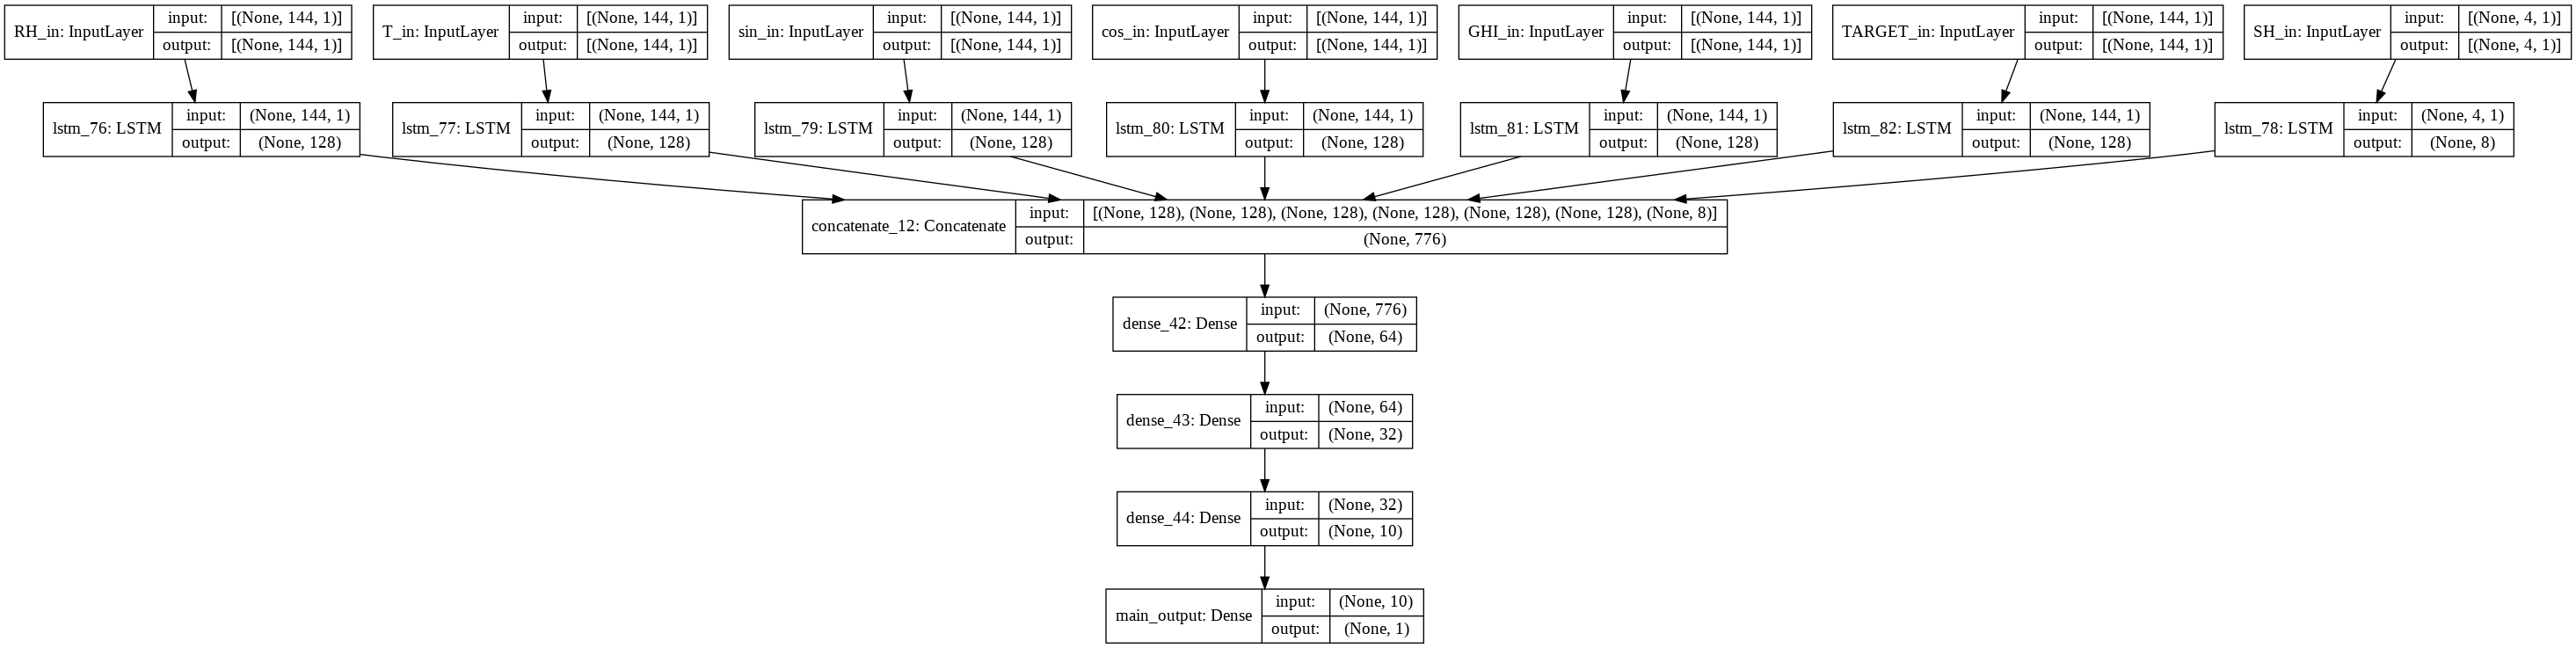

In [194]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

In [195]:
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [196]:
train_data = [RH_train, T_train, sin_train, cos_train, GHI_train, TARGET_train, SH_train]
test_data = [RH_test, T_test, sin_test, cos_test, GHI_test, TARGET_test, SH_test]

valid_data1 = ([RH_valid, T_valid, SH_valid, sin_valid, cos_valid, GHI_valid, TARGET_valid], Y_valid1)
valid_data2 = ([RH_valid, T_valid, SH_valid, sin_valid, cos_valid, GHI_valid, TARGET_valid], Y_valid2)

In [203]:
def train_data(input_X, input_Y, valid_data, X_test):

    LSTM_actual_pred = pd.DataFrame()

    for q in quantiles:
      model = Sequential()

      RH_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='RH_in')
      T_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='T_in')
      SH_input = keras.Input(shape=(SH_train.shape[1], SH_train.shape[2]), name='SH_in')
      sin_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='sin_in')
      cos_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='cos_in')
      GHI_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='GHI_in')
      TARGET_input = keras.Input(shape=(T_train.shape[1], T_train.shape[2]), name='TARGET_in')

      RH_body = layers.LSTM(128,  dropout=0.3)(RH_input)
      T_body = layers.LSTM(128, dropout=0.3)(T_input)
      SH_body = layers.LSTM(8, dropout=0.3)(SH_input)
      sin_body = layers.LSTM(128, dropout=0.3)(sin_input)
      cos_body = layers.LSTM(128, dropout=0.3)(cos_input)
      GHI_body = layers.LSTM(128, dropout=0.3)(GHI_input)
      TARGET_body = layers.LSTM(128, dropout=0.3)(TARGET_input)

      # RH_body = layers.LSTM(128)(RH_input)
      # T_body = layers.LSTM(128)(T_input)
      # SH_body = layers.LSTM(8)(SH_input)
      # sin_body = layers.LSTM(128)(sin_input)
      # cos_body = layers.LSTM(128)(cos_input)
      # GHI_body = layers.LSTM(128)(GHI_input)
      # TARGET_body = layers.LSTM(128)(TARGET_input)

      x = layers.Concatenate(axis=1)([RH_body, T_body, sin_body, cos_body, GHI_body, TARGET_body, SH_body])

      x = layers.Dense(64, activation='relu')(x)
      x = layers.Dense(32, activation='relu')(x)
      x = layers.Dense(10, activation='relu')(x)
      main_output = layers.Dense(1, activation='sigmoid', name='main_output')(x)
      model = Model(inputs=[RH_input, T_input, SH_input, sin_input, cos_input, GHI_input, TARGET_input], outputs=[main_output])
      model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')


      history = model.fit(input_X, input_Y, epochs=1000, batch_size=2000, validation_data=valid_data, verbose=2, shuffle=True, callbacks=[es, mc])
      print(q)
      pred = model.predict(X_test)
      pred = pred.reshape(pred.shape[0],1)
      # pred = scaler_y.inverse_transform(pred)
      pred = pd.DataFrame(pred)
      LSTM_actual_pred = pd.concat([LSTM_actual_pred,pred],axis=1)
        
    LSTM_actual_pred.columns=quantiles
    
    return LSTM_actual_pred

In [204]:
tock = time.time()
results_1 = train_data([RH_train, T_train, SH_train, sin_train, cos_train, GHI_train, TARGET_train], Y_train1, valid_data1, [RH_test, T_test, SH_test, sin_test, cos_test, GHI_test, TARGET_test])
results_2 = train_data([RH_train, T_train, SH_train, sin_train, cos_train, GHI_train, TARGET_train], Y_train2, valid_data2, [RH_test, T_test, SH_test, sin_test, cos_test, GHI_test, TARGET_test])
tick = time.time()

Streaming output truncated to the last 5000 lines.
19/19 - 4s - loss: 6.9397 - val_loss: 7.0341
Epoch 49/1000
19/19 - 4s - loss: 6.9285 - val_loss: 7.0215
Epoch 50/1000
19/19 - 4s - loss: 6.9257 - val_loss: 7.0226
Epoch 51/1000
19/19 - 4s - loss: 6.9256 - val_loss: 7.0241
Epoch 52/1000
19/19 - 4s - loss: 6.9282 - val_loss: 7.0221
Epoch 53/1000
19/19 - 4s - loss: 6.9249 - val_loss: 7.0225
Epoch 54/1000
19/19 - 4s - loss: 6.9251 - val_loss: 7.0228
Epoch 55/1000
19/19 - 4s - loss: 6.9249 - val_loss: 7.0211
Epoch 56/1000
19/19 - 4s - loss: 6.9242 - val_loss: 7.0209
Epoch 57/1000
19/19 - 4s - loss: 6.9256 - val_loss: 7.0220
Epoch 58/1000
19/19 - 4s - loss: 6.9260 - val_loss: 7.0229
Epoch 59/1000
19/19 - 4s - loss: 6.9236 - val_loss: 7.0222
Epoch 60/1000
19/19 - 4s - loss: 6.9232 - val_loss: 7.0197
Epoch 61/1000
19/19 - 4s - loss: 6.9228 - val_loss: 7.0200
Epoch 62/1000
19/19 - 4s - loss: 6.9235 - val_loss: 7.0275
Epoch 63/1000
19/19 - 4s - loss: 6.9255 - val_loss: 7.0240
Epoch 64/1000
19/19

In [205]:
print('소요시간 :', tick-tock)

소요시간 : 12144.691081762314


In [206]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission2 = submission.set_index('id')
submission3 = not_minus(submission2)

In [207]:
submission3.to_csv('submission_LSTM.csv')
!cp submission_LSTM.csv "drive/My Drive/"